In [1]:
import pandas as pd
import numpy as np
import scipy

In [2]:
import math as m

In [3]:
df=pd.read_excel("file.xlsx") 

In [4]:
df

,"Задержка, нс",Интенсивность Na I 330.24 нм,SE,K 404.414 интенсивность,SE.1,"T, K",SE(T),"Ne, cm-3",SE(Ne)
0,500,7514.84396,476.10945,4062.66594,339.049,11160,460,460630000000000000,5516320000000000
1,750,5203.17760,311.22042,3523.60950,261.361,9070,620,120978000000000000,8490570000000000
2,1000,3019.74546,159.50829,3290.13220,221.179,8010,430,41781900000000000,9520250000000000
3,1250,3518.56412,276.24331,2445.47059,199.793,6990,400,23834500000000000,4641110000000000
4,1500,3191.24572,257.59178,2681.43580,246.388,6770,350,13100000000000000,820700000000000
5,2000,3110.56996,388.48582,2824.07872,230.022,6170,390,9020000000000000,460000000000000
6,2500,4871.58925,333.56105,2333.55213,165.970,6070,180,8040000000000000,320800000000000
7,3000,4738.03161,355.98870,2921.55778,121.481,5690,210,6540000000000000,458600000000000


In [5]:
import matplotlib.pyplot as plt

# Пишем класс для f

Создание класса будет полезно в будущем, если я решу летом сделать ГУИ для этой задачи (в образовательных целях).

Сперва напишу класс для того, чтобы пересчитывать partfunc на 2 вектора, а не на 2 числа. Просто, скажем в жайле K 1.tsv нас интересуют 2 вектора - колонки номер 3 и 4. 

In [10]:
class PF():
    def calc(self,pd_vec1,pd_vec2,T):
        koef=(-1)*11604/T
        #print(koef)
        #print(np.array(pd_vec1)*np.exp(np.array(pd_vec2)*koef))
        return np.sum(np.array(pd_vec1,dtype = np.object)*np.array(np.exp(np.array(pd_vec2)*koef),dtype = np.object))
        

In [11]:
a=PF()
tt=a.calc([2,3,4,5],[1,2,3,4],-11604)

In [12]:
tt

380.9366298121819

In [13]:
class Q():
    def __init__(self,T=300,Ne=m.pow(10,17)):
        self.h=6.626*m.pow(10,-7)
        self.k_b=1.38
        self.T=T
        self.Ne=Ne
        
    def L(self):
        return m.sqrt(m.pow(self.h,2)/(2*m.pi*self.T*9.1094))
    
    def partfunc(self, file_):
        calcul=PF()
        return calcul.calc(file_[0],file_[1],self.T)
        #return file_[0]*m.exp(((-1)*file_[1]*11604)/self.T)
    
    def alpha(self,f1,f2,Eion):
        return (2/m.pow(self.L(),3))*(self.partfunc(f2)/self.partfunc(f1))*(m.pow(10,-6)/self.Ne)*m.exp(((-1)*Eion*11604)/self.T)
    
    def nt1quot(self,f1,f2,f3,Eion1,Eion2):
        if (Eion2==0):
            return 1/(1+(2*self.alpha(f1,f2,Eion1)))
        else:
            return 1/(1+(2*self.alpha(f1,f2,Eion1))+self.alpha(f2,f3,Eion2))
        
    def ion1quot(self,f1,f2,f3,Eion1,Eion2):
        if (Eion2==0):
            return self.alpha(f1,f2,Eion1)/(1+(2*self.alpha(f1,f2,Eion1)))
        else:
            return self.alpha(f1,f2,Eion1)/(1+(2*self.alpha(f1,f2,Eion1))+self.alpha(f2,f3,Eion2))
    
    def ret_stage_1(self,filepartfunc,Ex,f1,f2,f3,Eion1,Eion2):
        return (self.partfunc(filepartfunc)*m.exp((Ex*11604)/self.T))/self.nt1quot(f1,f2,f3,Eion1,Eion2)
    
    def ret_stage_2(self,filepartfunc,Ex,f1,f2,f3,Eion1,Eion2):
        return (self.partfunc(filepartfunc)*m.exp((Ex*11604)/self.T))/self.ion1quot(f1,f2,f3,Eion1,Eion2)
        
    def main(self,stage,filepartfunc,Ex,f1,f2,f3,Eion1,Eion2):
        if (stage==1):
            return self.ret_stage_1(filepartfunc,Ex,f1,f2,f3,Eion1,Eion2)
        if (stage==2):
            return self.ret_stage_2(filepartfunc,Ex,f1,f2,f3,Eion1,Eion2)
        if ((stage>2) or (stage<0)):
            return "Error, No data"

Нужен класс для чтения tsv файлов и формирования из них pandas объектов из нужных столбцов, ведь нам нужны третий и четвётртый столбцы, которые потом запихивать в list чтобы вставлять их в в модель в команде ниже. 

In [67]:
class pd_list_form():
    def read_(self,filename):
        df=pd.read_csv(filename,sep="\t")
        return list([df['g'],df['Level (eV)']])
    
    def main(self,filename):
        return self.read_(filename)

In [68]:
read_tsv=pd_list_form()

In [69]:
f1_K=read_tsv.main("K_1.tsv")
f2_K=read_tsv.main("K_2.tsv")
f3_K=read_tsv.main("K_3.tsv")
f1_N=read_tsv.main("Na_1.tsv")
f2_N=read_tsv.main("Na_2.tsv")
f3_N=read_tsv.main("Na_3.tsv")

In [72]:
a=Q(T=11160,Ne=460630000000000000)

In [15]:
#tt=a.main(filepartfunc=[2,1.60995783],Ex=3.065,f1=[2,1.60995783],f2=[5,20.147767],f3=[2,0.268475],
#         Eion1=4.34066354,Eion2=31.625,stage=1)

In [73]:
tt=a.main(filepartfunc=f1_K,Ex=3.065,f1=f1_K,f2=f2_K,f3=f3_K,
         Eion1=4.34066354,Eion2=31.625,stage=1)

In [74]:
tt

4390.856328024759

Далее будет длинный класс, который будет уже непосредственно самой функцией f которую мы потом будем дифференцировать.

In [92]:
class f():
    def __init__(self,T,Ne,lamb_K=404.414,lamb_N=330.24,Ex_K=3.065,
                Eion1_K=4.34066354, Eion2_K=31.625, Ex_N=3.75,
                Eion1_N=5.1390769, Eion2_N=47.28636, mass_K=39.0983,
                mass_N=22.9898, intens_K=4062.66594, intens_N=7514.84396,
                alpha_K=0.11,alpha_N=0.0464):
        read_tsv=pd_list_form()
        self.f1_K=read_tsv.main("K_1.tsv")
        self.f2_K=read_tsv.main("K_2.tsv")
        self.f3_K=read_tsv.main("K_3.tsv")
        self.f1_N=read_tsv.main("Na_1.tsv")
        self.f2_N=read_tsv.main("Na_2.tsv")
        self.f3_N=read_tsv.main("Na_3.tsv")
        self.T=T
        self.Ne=Ne
        self.lamb_K=lamb_K
        self.lamb_N=lamb_N
        self.Ex_K=Ex_K
        self.Eion1_K=Eion1_K
        self.Eion2_K=Eion2_K
        self.Ex_N=Ex_N
        self.Eion1_N=Eion1_N
        self.Eion2_N=Eion2_N
        self.mass_K=mass_K
        self.mass_N=mass_N
        self.intens_K=intens_K
        self.intens_N=intens_N
        self.alpha_K=alpha_K
        self.alpha_N=alpha_N
        
    def q_K(self):
        q=Q(T=self.T,Ne=self.Ne)
        return q.main(filepartfunc=self.f1_K,Ex=self.Ex_K,f1=self.f1_K,f2=self.f2_K,f3=self.f3_K,
                      Eion1=self.Eion1_K,Eion2=self.Eion2_K,stage=1)
    
    def q_N(self):
        q=Q(T=self.T,Ne=self.Ne)
        return q.main(filepartfunc=self.f1_N,Ex=self.Ex_N,f1=self.f1_N,f2=self.f2_N,f3=self.f3_N,
                      Eion1=self.Eion1_N,Eion2=self.Eion2_N,stage=1)
    
    def upp(self):
        return self.intens_K*self.alpha_K*self.lamb_K*self.mass_K*self.q_K()
    
    def dow(self):
        return self.intens_N*self.alpha_N*self.lamb_N*self.mass_N*self.q_N()
    
    def main(self):
        return self.upp()/self.dow()

In [93]:
aa=f(T=11160,Ne=460630000000000000,intens_K=4062.66594, intens_N=7514.84396)

In [94]:
aa.main()

2.9155609783318583

Далее напишу по быстрому свой класс для нахождения примерного значения первой (раньше я чего-то решил, что нужна именно вторая производная, но, сейчас я близок к мнению, что нужен квадрат первой производной) производной по уравнению:
<font size=5>$f^{'}(x)=\frac{f(x-2h)-8f(x-h)+8f(x+h)-f(x+2h)}{12h}$</font>

In [180]:
class my_deriv():
    def __init__(self,h=100,T=11160,Ne=460630000000000000,intens_K=4062.66594, intens_N=7514.84396,
                param="T"):
        self.h=h
        self.T=T
        self.Ne=Ne
        self.intens_K=intens_K
        self.intens_N=intens_N
        self.param=param
    
    def deriv_t(self):
        f1=f(T=self.T-(2*self.h),Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N)
        f2=f(T=self.T-(self.h),Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N)
        f4=f(T=self.T+(self.h),Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N)
        f5=f(T=self.T+(2*self.h),Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N)
        #return (f1.main()-(8*f2.main())+(8*f4.main())-f5.main())/(12*self.h)
        return (f4.main()-f2.main())/(2*self.h)
    
    def deriv_n(self):
        f1=f(T=self.T,Ne=self.Ne-(2*self.h),intens_K=self.intens_K, intens_N=self.intens_N)
        f2=f(T=self.T,Ne=self.Ne-(self.h),intens_K=self.intens_K, intens_N=self.intens_N)
        f4=f(T=self.T,Ne=self.Ne+(self.h),intens_K=self.intens_K, intens_N=self.intens_N)
        f5=f(T=self.T,Ne=self.Ne+(2*self.h),intens_K=self.intens_K, intens_N=self.intens_N)
        #return (f1.main()-(8*f2.main())+(8*f4.main())-f5.main())/(12*self.h)
        return (f4.main()-f2.main())/(2*self.h)
    
    def deriv_in(self):
        f1=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N-(2*self.h))
        f2=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N-(self.h))
        f4=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N+(self.h))
        f5=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K, intens_N=self.intens_N+(2*self.h))
        #return (f1.main()-(8*f2.main())+(8*f4.main())-f5.main())/(12*self.h)
        return (f4.main()-f2.main())/(2*self.h)
    
    def deriv_ik(self):
        f1=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K-(2*self.h), intens_N=self.intens_N)
        f2=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K-(self.h), intens_N=self.intens_N)
        f4=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K+(self.h), intens_N=self.intens_N)
        f5=f(T=self.T,Ne=self.Ne,intens_K=self.intens_K+(2*self.h), intens_N=self.intens_N)
        #return (f1.main()-(8*f2.main())+(8*f4.main())-f5.main())/(12*self.h)
        return (f4.main()-f2.main())/(2*self.h)
        
    def calc(self):
        if (self.param=="T"):
            return self.deriv_t()
        if (self.param=="N"):
            return self.deriv_n()
        if (self.param=="IN"):
            return self.deriv_in()
        if (self.param=="IK"):
            return self.deriv_ik()

In [181]:
a=my_deriv(h=5,T=6170,Ne=9020000000000000,intens_K=2824.07872, intens_N=3110.56996,param="IK")

In [182]:
m.pow(a.calc(),2)*m.pow(230.022,2)

0.17586993065014478

Далее нужно написать класс, который будет получать вектора ошибок, разной природы, и далее накинем на него ещё и ковариацию, чтобы он полностью реализовывал закон распространения ошибки. Важно, df должен быть импортирован заранее (файл с экспериментальными данными)

In [187]:
class vector_derivative():
    def __init__(self,df):
        self.df=df
    
    def vec_t(self):
        res=list()
        for i in range(len(df.iloc[:,0])):
            model=my_deriv(h=5,T=df.iloc[i,5],Ne=df.iloc[i,7],
                           intens_K=df.iloc[i,3], intens_N=df.iloc[i,1],param="T")
            res.append(m.pow(model.calc(),2)*m.pow(df.iloc[i,6],2))
        return res
    
    def vec_n(self):
        res=list()
        for i in range(len(df.iloc[:,0])):
            model=my_deriv(h=3208000000000000,T=df.iloc[i,5],Ne=df.iloc[i,7],
                           intens_K=df.iloc[i,3], intens_N=df.iloc[i,1],param="N")
            res.append(m.pow(model.calc(),2)*m.pow(df.iloc[i,8],2))
        return res
    
    def vec_ik(self):
        res=list()
        for i in range(len(df.iloc[:,0])):
            model=my_deriv(h=5,T=df.iloc[i,5],Ne=df.iloc[i,7],
                           intens_K=df.iloc[i,3], intens_N=df.iloc[i,1],param="IK")
            res.append(m.pow(model.calc(),2)*m.pow(df.iloc[i,4],2))
        return res
    
    def vec_in(self):
        res=list()
        for i in range(len(df.iloc[:,0])):
            model=my_deriv(h=5,T=df.iloc[i,5],Ne=df.iloc[i,7],
                           intens_K=df.iloc[i,3], intens_N=df.iloc[i,1],param="IN")
            res.append(m.pow(model.calc(),2)*m.pow(df.iloc[i,2],2))
        return res
        
    def main(self):
        return np.array([self.vec_t(),self.vec_n(),self.vec_ik(),self.vec_in()])

In [188]:
aaaa=vector_derivative(df=df)

In [189]:
res=aaaa.main()

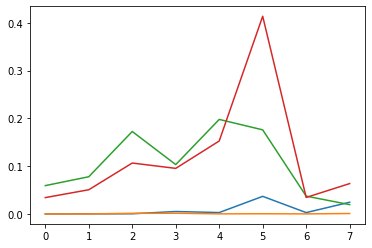

In [191]:
plt.plot(res[0,:])
plt.plot(res[1,:])
#plt.plot((res[2,:]+res[3,:]))
plt.plot(res[2,:])
plt.plot(res[3,:])
plt.show()

In [149]:
1e10

10000000000.0

In [127]:
df=pd.read_excel("file.xlsx") 

In [128]:
df

,"Задержка, нс",Интенсивность Na I 330.24 нм,SE,K 404.414 интенсивность,SE.1,"T, K",SE(T),"Ne, cm-3",SE(Ne)
0,500,7514.84396,476.10945,4062.66594,339.049,11160,460,460630000000000000,5516320000000000
1,750,5203.17760,311.22042,3523.60950,261.361,9070,620,120978000000000000,8490570000000000
2,1000,3019.74546,159.50829,3290.13220,221.179,8010,430,41781900000000000,9520250000000000
3,1250,3518.56412,276.24331,2445.47059,199.793,6990,400,23834500000000000,4641110000000000
4,1500,3191.24572,257.59178,2681.43580,246.388,6770,350,13100000000000000,820700000000000
5,2000,3110.56996,388.48582,2824.07872,230.022,6170,390,9020000000000000,460000000000000
6,2500,4871.58925,333.56105,2333.55213,165.970,6070,180,8040000000000000,320800000000000
7,3000,4738.03161,355.98870,2921.55778,121.481,5690,210,6540000000000000,458600000000000


In [144]:
for i in range(len(df.iloc[:,0])):
    print(df.iloc[i,0],df.iloc[i,1])

500 7514.84396
750 5203.1776
1000 3019.74546
1250 3518.56412
1500 3191.24572
2000 3110.56996
2500 4871.58925
3000 4738.03161


# Далее реализую библиотечное дифференцирование